In [93]:
# Predicting soluble expression 

features = [
    u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm', u'tot_nlpstat_pm', u'tot_burunsat_pm',
    u'tot_hbond_pm', u'tot_NLconts_pm', u'tot_nlsurfaceE_pm',
    u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc', u'SR_1_hbond_pm',
    u'SR_1_burunsat_pm', u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', 
    u'SR_2_total_score', u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_hbond_pm', 
    u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm', 
    u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', u'SR_3_hbond_pm',
    u'SR_3_burunsat_pm', u'SR_3_pstat_pm', u'SR_3_nlpstat_pm',
    u'SR_4_total_score', u'SR_4_fa_rep', u'SR_4_hbond_sc', u'SR_4_hbond_pm', 
    u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm', 
    u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_interf_E_1_2',
    u'SR_5_dsasa_1_2', u'SR_5_hbond_pm', u'SR_5_burunsat_pm'
]

In [94]:
# get the expression data 

import pandas

df = pandas.read_csv( '../data_sets/experimental/expr_144_mutants.csv', index_col=0 ) 
#df.expression = df.expression.astype( bool ).astype( int ) 

# get the features (enzyme design) 

f = pandas.read_csv( '../data_sets/rosetta/enzyme_design_noncovalent.csv', sep='\s+' )
f.description = f.description.str.split( '_' ).str[1]
f = f.groupby( 'description' ).apply( lambda x: x.sort_values( by='SR_3_total_score' ).head(4) )
f.index = f.description

df = df.join( f ).dropna()

df.shape

print len( df.expression[ df.expression > 0 ] ), 'positive class labels' 
print len( df.expression[ df.expression < 1 ] ), 'negative class labels' 

404 positive class labels
152 negative class labels


In [95]:
df.corr()[ [ 'expression' ] ].sort_values( 'expression' )

,expression
tot_total_neg_charges,-0.173465
SR_5_hbond_sc,-0.171772
SR_5_interf_E_1_2,-0.125714
SR_5_total_score,-0.125519
SR_5_burunsat_pm,-0.092141
SR_3_hbond_pm,-0.076566
SR_1_hbond_pm,-0.076566
SR_3_all_cst,-0.071878
SR_1_all_cst,-0.071878
SR_4_hbond_pm,-0.066317


In [96]:
# we will use 40ish features and 131 protein models (each is average of lowest 10 by total_score) 
# to train an SVM classifier 


from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X = df[ features ] 
X = scaler.fit_transform( X ) 
y = df[ 'expression' ] 

X.shape, y.shape

print y.mean()

0.726618705036


In [97]:
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
from sklearn.metrics import classification_report

pln = Pipeline([ ( 'pca', PCA(whiten=True) ), ( 'svm', SVC( class_weight='balanced' ) ), ])
param_grid = dict( svm__C=[0.3,3,30], svm__gamma=[1e-4,1e-3,1e-2], pca__n_components=[2,5,10,20] ) 
grid = GridSearchCV( pln, param_grid, cv=3 ) 
grid.fit( X, y ) 
y_pred = grid.predict( X ) 
print classification_report( y, y_pred ) 

             precision    recall  f1-score   support

          0       0.40      0.26      0.32       152
          1       0.75      0.85      0.80       404

avg / total       0.66      0.69      0.67       556



In [98]:
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
from sklearn.metrics import classification_report

pln = Pipeline([ ( 'pca', PCA() ), ( 'svm', SVC( class_weight='balanced' ) ), ])
param_grid = dict( svm__C=[0.3,3,30], svm__gamma=[1e-4,1e-3,1e-2], pca__n_components=[2,5,10,20] ) 
grid = GridSearchCV( pln, param_grid, cv=3 ) 
grid.fit( X, y ) 
y_pred = grid.predict( X ) 
print grid.best_params_
print classification_report( y, y_pred ) 

{'pca__n_components': 2, 'svm__C': 30, 'svm__gamma': 0.0001}
             precision    recall  f1-score   support

          0       0.43      0.19      0.26       152
          1       0.75      0.91      0.82       404

avg / total       0.66      0.71      0.67       556



In [65]:
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
from sklearn.metrics import classification_report

pln = Pipeline([ ( 'pca', PCA() ), ( 'svm', SVC( class_weight='balanced' ) ), ])
param_grid = dict( svm__C=[0.3,3,30], svm__gamma=[1e-4,1e-3,1e-2], pca__n_components=[2,5,10,20] ) 
grid = GridSearchCV( pln, param_grid, cv=3 ) 
grid.fit( X, y ) 
y_pred = grid.predict( X ) 
print classification_report( y, y_pred ) 

             precision    recall  f1-score   support

          0       0.49      0.60      0.54       114
          1       0.83      0.77      0.80       303

avg / total       0.74      0.72      0.73       417



Optimal number of features : 1


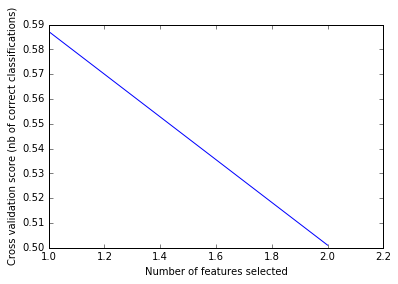

In [53]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

# # Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                            n_redundant=2, n_repeated=0, n_classes=8,
#                            n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
pca = PCA( n_components=2, whiten=True ) 
X = pca.fit_transform( X ) 
svc = SVC(kernel="linear", class_weight='balanced' )
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [ ]:
# streamlined version 

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, cross_val_score

cv = StratifiedKFold( y, n_folds=10, shuffle=True )
classifier = svm.SVC( kernel='linear', C=30 )
cross_val = cross_val_score( classifier, X, y, cv=cv) 

print 'mean accuracy:', cross_val.mean()

In [ ]:
# make a plot of cross validation performance with auc for each fold 

%matplotlib inline
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

cv = StratifiedKFold( y, n_folds=10, shuffle=True )
classifier = svm.SVC( kernel='rbf', probability=True, random_state=1 )

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

plt.figure( figsize=(10,10) )

for i, (train, test) in enumerate(cv):
    print i, 
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    print 'done,',  

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()